# Camera Pose Estimation with OpenCV

### Goal

The goal of this notebook is to estimate the camera pose w.r.t. a reference object of known geometry such as a chessboard.

* Input: intrinsic parameter $K$, an image of a reference object (e.g. chessboard) and its 3D geometry
* Output: camera pose $R, t$ w.r.t. the reference object

Given a set of 2D-3D correspondences, the below solves a Perspective-n-Point (PnP) problem and obtain $R, t$ that satisfy $\tilde{x} \sim K (R|t)\tilde{X}$.


## Libraries

In [1]:
%matplotlib notebook
import sys, os, cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from pycalib.plot import plotCamera


## Calibration parameters

**Important**
* Compare the pattern shown below with the pattern captured in the image.
* The numbers of rows and cols indicate **the numbers of CELLs, not corners**.
  * For example, an 18x9 ChAruco board has a 18 cells == 17 corners by 9 cells == 8 corners pattern.
  * In the case of the traditional chessboard, the rows and cols indicate the numbers of corners.

<IPython.core.display.Javascript object>


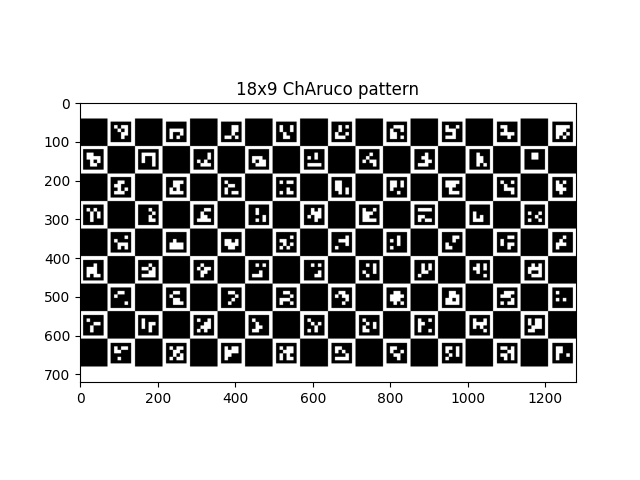

In [2]:
# Chessboard configuration
aruco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_250)
board = cv2.aruco.CharucoBoard_create(18, 9, 0.02, 0.015, aruco_dict)

# check if the board is correct
image = board.draw((1280, 720))

plt.figure()
plt.imshow(image, cmap='gray')
plt.title('18x9 ChAruco pattern')
plt.show()

# Input images capturing the chessboard above
input_files = '../data/charuco/*.jpg'


## Intrinsic Parameter

Use `incalib_charuco.ipynb` to get the intrinsic parameter.

In [3]:
K =  np.array([[586.95061044,   0.,         640.86534378],
               [  0.,         586.95061044, 356.28253051],
               [  0.,           0.,           1.        ]])

d =  np.array([[ 7.05473303e-01, -6.29813665e-01,  3.09176103e-04, -4.94115621e-04,
                -6.19825160e-02,  1.00148301e+00, -5.36482898e-01, -2.13796237e-01]])


print("Intrinsic parameter K = ", K)
print("Distortion parameters d = (k1, k2, p1, p2, k3, k4, k5, k6) = ", d)


Intrinsic parameter K =  [[586.95061044   0.         640.86534378]
 [  0.         586.95061044 356.28253051]
 [  0.           0.           1.        ]]
Distortion parameters d = (k1, k2, p1, p2, k3, k4, k5, k6) =  [[ 7.05473303e-01 -6.29813665e-01  3.09176103e-04 -4.94115621e-04
  -6.19825160e-02  1.00148301e+00 -5.36482898e-01 -2.13796237e-01]]


## 2D chesscorner detection and PnP

Translation : [[-0.15282824]
 [-0.08831077]
 [ 0.18748976]]
Rotation    : [[-0.06134041]
 [-0.42776571]
 [ 0.07785565]]
Distance from camera: 0.25750275937912764 m


<IPython.core.display.Javascript object>


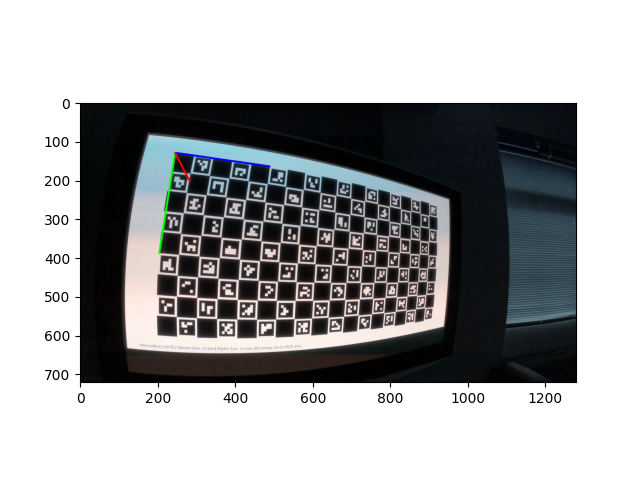

Translation : [[-0.29859717]
 [-0.08224826]
 [ 0.21329782]]
Rotation    : [[0.08321439]
 [0.01186847]
 [0.02118434]]
Distance from camera: 0.37605984265407466 m


<IPython.core.display.Javascript object>


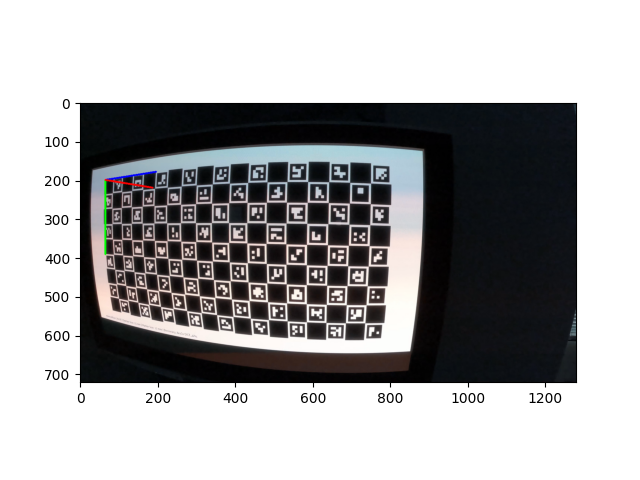

Translation : [[-0.08425655]
 [-0.08611633]
 [ 0.17222916]]
Rotation    : [[ 0.06471074]
 [-0.30441992]
 [ 0.0828662 ]]
Distance from camera: 0.21018580944109622 m


<IPython.core.display.Javascript object>


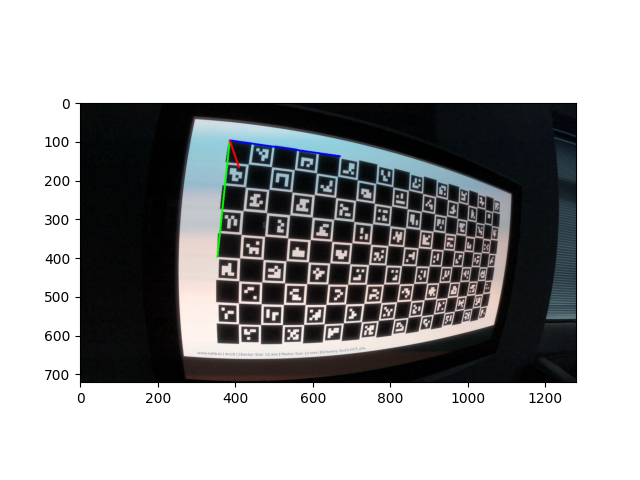

Translation : [[-0.09015663]
 [-0.11072796]
 [ 0.20427223]]
Rotation    : [[-0.24132787]
 [-0.13054824]
 [-0.01240381]]
Distance from camera: 0.24923089786272626 m


<IPython.core.display.Javascript object>


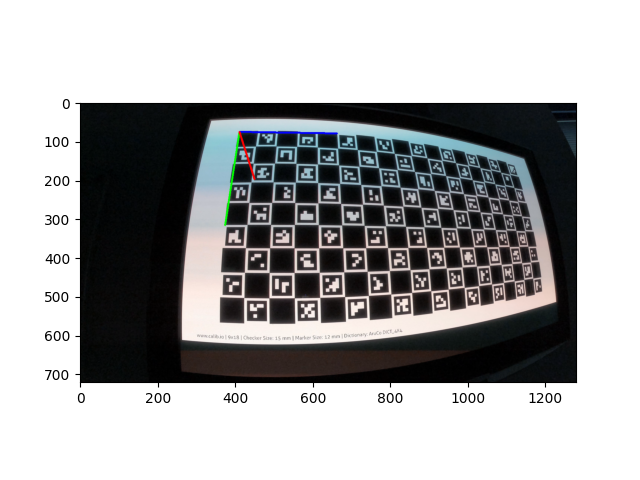

Translation : [[-0.18161173]
 [-0.07188079]
 [ 0.32115375]]
Rotation    : [[-0.22451262]
 [ 0.28144525]
 [-0.03793347]]
Distance from camera: 0.3758848208501591 m


<IPython.core.display.Javascript object>


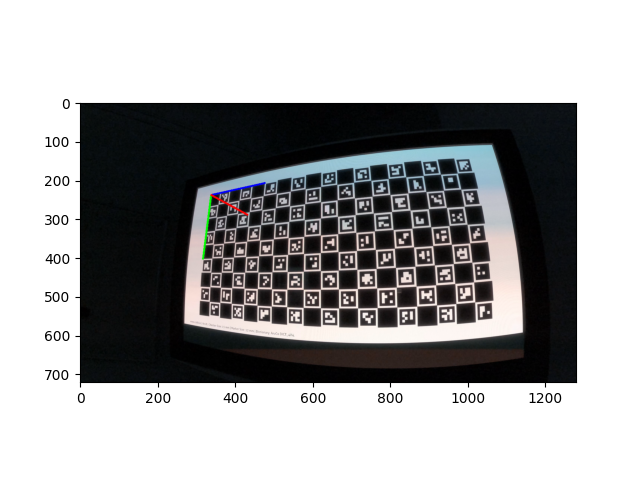

Translation : [[-0.24689826]
 [-0.07800638]
 [ 0.34748659]]
Rotation    : [[-0.07745919]
 [ 0.1797457 ]
 [ 0.00421436]]
Distance from camera: 0.4333482135724937 m


<IPython.core.display.Javascript object>


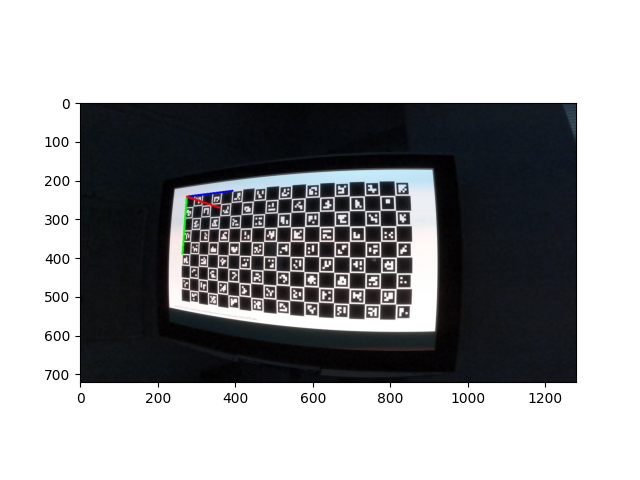

Translation : [[-0.11394448]
 [-0.05407097]
 [ 0.19254513]]
Rotation    : [[ 0.05109579]
 [-0.50177971]
 [-0.0143938 ]]
Distance from camera: 0.23017523593341568 m


<IPython.core.display.Javascript object>


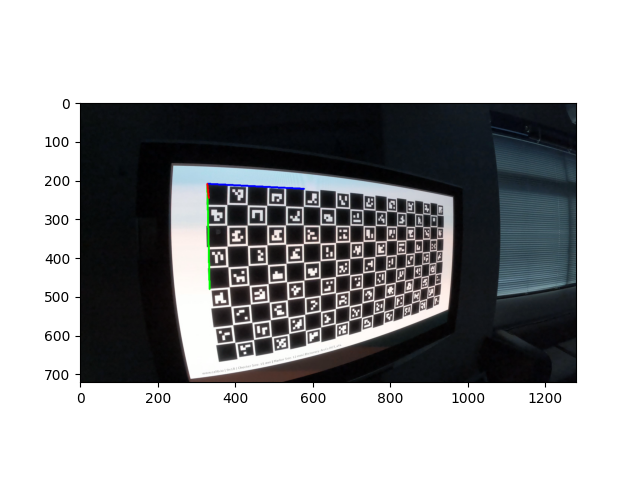

Translation : [[-0.31849359]
 [-0.10154846]
 [ 0.27217227]]
Rotation    : [[ 0.2077971 ]
 [ 0.07950309]
 [-0.07546394]]
Distance from camera: 0.43107771560848734 m


<IPython.core.display.Javascript object>


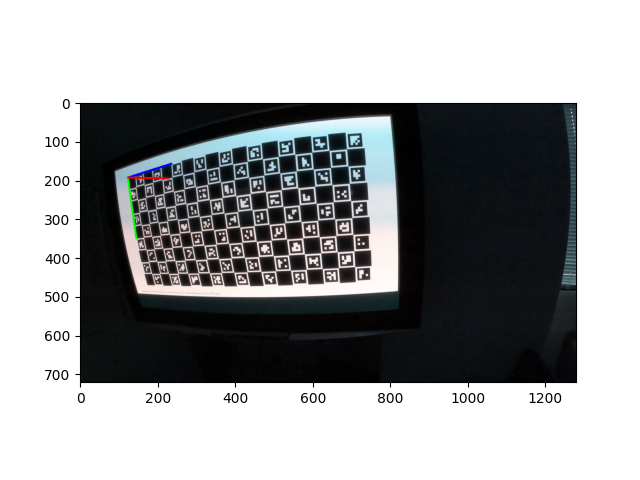

Translation : [[-0.18705112]
 [-0.11059676]
 [ 0.25122538]]
Rotation    : [[-0.28174508]
 [-0.11102519]
 [-0.01134046]]
Distance from camera: 0.3321655560611021 m


<IPython.core.display.Javascript object>


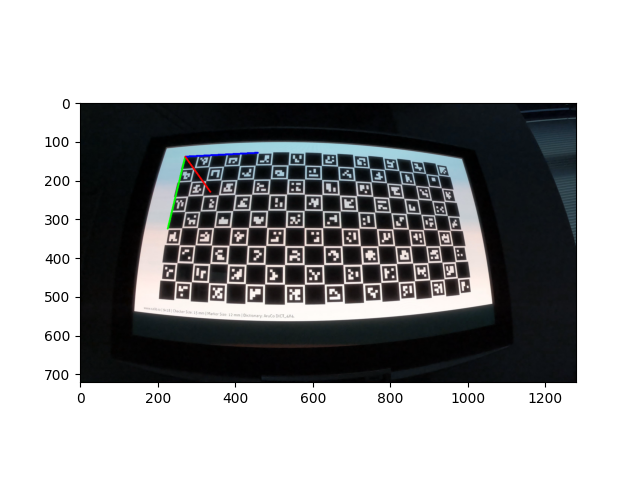

In [4]:
for i in sorted(glob(input_files)):
    frame = cv2.imread(i)
    corners, ids, rejected_points = cv2.aruco.detectMarkers(frame, aruco_dict)
    if corners is None or ids is None:
        continue

    #if len(corners) != len(ids) or len(corners) == 0:
    #    return None

    try:
        ret, c_corners, c_ids = cv2.aruco.interpolateCornersCharuco(corners,
                                                                    ids,
                                                                    frame,
                                                                    board)
        ret, p_rvec, p_tvec = cv2.aruco.estimatePoseCharucoBoard(c_corners,
                                                                c_ids,
                                                                board,
                                                                K,
                                                                d, None, None, False)
        if p_rvec is None or p_tvec is None:
            continue
        if np.isnan(p_rvec).any() or np.isnan(p_tvec).any():
            continue
        cv2.drawFrameAxes(frame,
                        K,
                        d,
                        p_rvec,
                        p_tvec,
                        0.1)
        # cv2.aruco.drawDetectedCornersCharuco(frame, c_corners, c_ids)
        # cv2.aruco.drawDetectedMarkers(frame, corners, ids)
        # cv2.aruco.drawDetectedMarkers(frame, rejected_points, borderColor=(100, 0, 240))
    except cv2.error:
        continue

    print('Translation : {0}'.format(p_tvec))
    print('Rotation    : {0}'.format(p_rvec))
    print('Distance from camera: {0} m'.format(np.linalg.norm(p_tvec)))

    plt.figure()
    plt.imshow(frame)
    plt.show()
